# My First Kaggle Notebook -- 
# Version 1
# Started Kaggle now but not new to Data Science

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [3]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [7]:
print(train.columns)
print('The number of columns present in Train dataset are ', len(train.columns))

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')
The number of columns present in Train dataset are  58


In [8]:
train.rename(columns = {"Class" : "target"}, inplace = True)
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,target
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [9]:
print(train.columns)
print('The number of columns present in Train dataset are ', len(train.columns))

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'target'],
      dtype='object')
The number of columns present in Train dataset are  58


 AB-GL Fifty-six **anonymized** health characteristics. All are 
numeric except for EJ, which is categorical.
So all these 56 columns are health characteristics

In [10]:
print(train.nunique())

Id        617
AB        217
AF        599
AH        227
AM        605
AR        130
AX        427
AY        148
AZ        484
BC        259
BD        617
BN         53
BP        612
BQ        515
BR        566
BZ        115
CB        553
CC        602
CD        584
CF        586
CH        135
CL        123
CR        595
CS        576
CU        307
CW        426
DA        611
DE        616
DF        137
DH        191
DI        571
DL        604
DN        576
DU        253
DV         39
DY        590
EB        439
EE        513
EG        610
EH        127
EJ          2
EL        311
EP        275
EU        455
FC        600
FD        337
FE        615
FI        498
FL        388
FR        435
FS        161
GB        560
GE        264
GF        611
GH        596
GI        615
GL        355
target      2
dtype: int64


**EJ have only two values so it is categorical**

In [11]:
train.duplicated().sum()

0

**There is no duplicate rows in any cell**

**Make report using Switviz to see its detailed EDA analysis**

In [12]:
#report = sv.analyze(train)
#report.show_html()

# Working with missing values****

In [13]:
contains_missing = ['BQ','CB','CC','DU','EL','FC','FL','FS','GL']

for col in contains_missing :
   mean_value = train[col].mean()
   train[col].fillna(value=mean_value, inplace=True)  # Replace NaN values with the mean value

In [14]:
correlated_data = train.corr()
#print(correlated_data)

/tmp/ipykernel_20/3652691610.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlated_data = train.corr()


<Axes: >

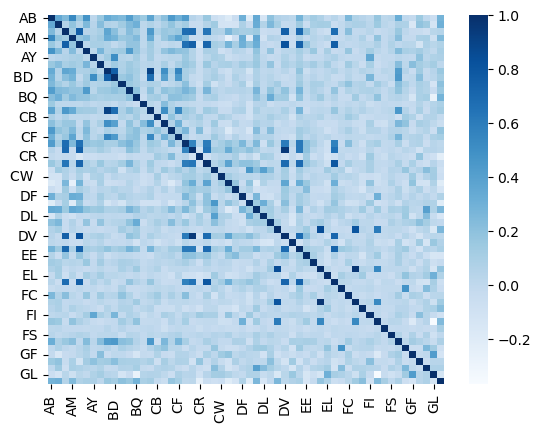

In [15]:
sns.heatmap(data=correlated_data, cmap='Blues', annot=False)

In [16]:
one_hot_encoded = pd.get_dummies(train[['EJ']])
print(one_hot_encoded.head())

   EJ_A  EJ_B
0     0     1
1     1     0
2     0     1
3     0     1
4     0     1


In [17]:
len(one_hot_encoded.columns)

2

In [18]:
for column in one_hot_encoded.columns:
   train.insert(len(train.columns), column , one_hot_encoded.loc[:, column])

In [19]:
train.drop(['EJ', 'Id'], axis=1, inplace=True)

In [20]:
len(train.columns)

58

In [21]:
target_column = train["target"]
train.drop(["target"], inplace=True, axis=1) # Remove target column for training the data
target_column

0      1
1      0
2      0
3      0
4      1
      ..
612    0
613    0
614    0
615    0
616    0
Name: target, Length: 617, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix

**Our dataset have high variation in data. Ex. look at columns 'AB', 'AH', 'AF', 'AR' and others. So their are lots of descripency and randomness. So we must have to Normalize it**

In [23]:
def standardization(dataset) :
    # Create a StandardScaler object.
    scaler = StandardScaler()
    # Fit and transform the data.
    X_scaled = scaler.fit_transform(dataset)
    X_scaled

In [24]:
standardization(train)

In [25]:
# merged_train ------- input feature
# target_column ------ output feature
"""
X_train ------ features that will be used to train the model.
X_test  ------ features that will be used to test the model.
y_train ------ labels that correspond to the features in X_train.
y_test  ------ labels that correspond to the features in X_test.
"""
X_train, X_test, y_train, y_test = train_test_split(train, target_column, test_size=0.2, random_state = 60)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [27]:
# Create the models.
rf_model = RandomForestClassifier()

xgboost_model = XGBClassifier()

svm_model = SVC()

logistic_regression_model = LogisticRegression()


In [28]:
models = [rf_model, xgboost_model, svm_model]
#Dont use logistic_regression_model for now

for model in models :

      # Fit the model to the training data
      model.fit(X_train, y_train)

      # Predict the training data
      y_train_pred = model.predict(X_train)

      # Predict the test data
      y_test_pred = model.predict(X_test)

      # Calculate the evaluation metrics on the training data
      train_accuracy = accuracy_score(y_train, y_train_pred)
      train_precision = precision_score(y_train, y_train_pred)
      train_recall = recall_score(y_train, y_train_pred)
      train_f1 = f1_score(y_train, y_train_pred)
      train_log_loss = log_loss(y_train, y_train_pred)

      # Calculate the evaluation metrics on the test data
      test_accuracy = accuracy_score(y_test, y_test_pred)
      test_precision = precision_score(y_test, y_test_pred)
      test_recall = recall_score(y_test, y_test_pred)
      test_f1 = f1_score(y_test, y_test_pred)
      test_log_loss = log_loss(y_test, y_test_pred)

      # Print the evaluation metrics
      print('Training accuracy:', train_accuracy)
      print('Training precision:', train_precision)
      print('Training recall:', train_recall)
      print('Training f1:', train_f1)
      print('Training log loss:', train_log_loss)
      print()
      print('Test accuracy:', test_accuracy)
      print('Test precision:', test_precision)
      print('Test recall:', test_recall)
      print('Test f1:', test_f1)
      print('Test log loss:', test_log_loss)

      # Print the confusion matrix for the test data
      print(confusion_matrix(y_test, y_test_pred))
      print('-------------------------------------------------------------')
      print('-------------------------------------------------------------')

Training accuracy: 1.0
Training precision: 1.0
Training recall: 1.0
Training f1: 1.0
Training log loss: 2.2204460492503136e-16

Test accuracy: 0.9354838709677419
Test precision: 0.9333333333333333
Test recall: 0.6666666666666666
Test f1: 0.7777777777777778
Test log loss: 2.325396992846268
[[102   1]
 [  7  14]]
-------------------------------------------------------------
-------------------------------------------------------------
Training accuracy: 1.0
Training precision: 1.0
Training recall: 1.0
Training f1: 1.0
Training log loss: 2.2204460492503136e-16

Test accuracy: 0.9435483870967742
Test precision: 0.85
Test recall: 0.8095238095238095
Test f1: 0.8292682926829269
Test log loss: 2.0347223687404847
[[100   3]
 [  4  17]]
-------------------------------------------------------------
-------------------------------------------------------------
Training accuracy: 0.8417849898580122
Training precision: 0.7647058823529411
Training recall: 0.14942528735632185
Training f1: 0.25
Trainin

**Use XGBoost**

In [29]:
contains_missing = ['BQ','CB','CC','DU','EL','FC','FL','FS','GL']

for col in contains_missing :
   mean_value = test[col].mean()
   test[col].fillna(value=mean_value, inplace=True)  # Replace NaN values with the mean value

In [30]:
one_hot_encoded = pd.get_dummies(test[['EJ']])
print(one_hot_encoded.head())

   EJ_A
0     1
1     1
2     1
3     1
4     1


In [31]:
test.drop(['EJ', 'Id'], axis=1, inplace=True)

In [32]:
for column in one_hot_encoded.columns:
   test.insert(len(test.columns), column , one_hot_encoded.loc[:, column])

In [33]:
test["EJ_B"] = 0

In [34]:
test["EJ_B"]

0    0
1    0
2    0
3    0
4    0
Name: EJ_B, dtype: int64

In [35]:
standardization(test)

In [36]:
xgboost_model.fit(X_train, y_train)

# Predict the test data
y_test_pred = model.predict(test)

In [37]:
y_test_pred

array([0, 0, 0, 0, 0])

In [38]:
# Get the probabilities for the test data
y_proba = xgboost_model.predict_proba(test)

In [39]:
y_proba

array([[0.96021247, 0.03978755],
       [0.96021247, 0.03978755],
       [0.96021247, 0.03978755],
       [0.96021247, 0.03978755],
       [0.96021247, 0.03978755]], dtype=float32)

In [40]:
# Calculate the probability for the positive class
positive_class_probability = y_proba[:, 1]

# Calculate the probability for the negative class
negative_class_probability = y_proba[:, 0]

# Print the probabilities
print("Positive class probability:", positive_class_probability)
print("Negative class probability:", negative_class_probability)

Positive class probability: [0.03978755 0.03978755 0.03978755 0.03978755 0.03978755]
Negative class probability: [0.96021247 0.96021247 0.96021247 0.96021247 0.96021247]


In [41]:
test_2 = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [42]:

submissions = pd.DataFrame(
    {"Id": test_2['Id'], "class_0": negative_class_probability, "class_1": 1 - negative_class_probability} 
)
submissions.head()

,Id,class_0,class_1
0,00eed32682bb,0.960212,0.039788
1,010ebe33f668,0.960212,0.039788
2,02fa521e1838,0.960212,0.039788
3,040e15f562a2,0.960212,0.039788
4,046e85c7cc7f,0.960212,0.039788


In [43]:
submissions.to_csv("submission.csv", index=False)

In [44]:
pd.read_csv('/kaggle/working/submission.csv').head()

,Id,class_0,class_1
0,00eed32682bb,0.960212,0.039788
1,010ebe33f668,0.960212,0.039788
2,02fa521e1838,0.960212,0.039788
3,040e15f562a2,0.960212,0.039788
4,046e85c7cc7f,0.960212,0.039788
